In [1]:
import ast
def unpack_cached_data(channel):
    print("Unpacking data: ", channel)
    channel_file = open(channel, "r")
    cached_data = channel_file.read()
    videos = ast.literal_eval(cached_data)
    return videos

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

import os
from sklearn.feature_extraction import text 

import pyLDAvis
import pyLDAvis.gensim

import gensim
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import nltk
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import matplotlib.pyplot as plt

context_stop_words = []

lexical_tags = ["NN","NNS", "NNP", "NNPS",
                "JJ","JJR","JJS",
                "VB","VBD","VBG","VBN","VBP","VBZ",
                "RB","RBR","RBS",
                "PRP","PRP$",
                "WP","WP$","WRB"]


## Helper function to print the words of each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]+ ' ' + str(round(topic[i], 2))
              +' \n ' for i in topic.argsort()[:-no_top_words - 1:-1]]))

        
## Helper Function to break a string into chunks        
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def remove_stopwords(tokens):
    #stopwords = nltk.corpus.stopwords.words('english')
    
    stop_words = set(nltk.corpus.stopwords.words('english'))

    new_stopwords_list = stop_words.union(context_stop_words)
    
    return [word for word in tokens if word not in new_stopwords_list]


# Takes tokenized text and removes all proper nouns with nltk tags
def remove_functionwords(token):
    # Break down each word into their category for tags
    tags = pos_tag(token)
    
    # Remove all the words with the proper noun tags or possessives or proper noun purals
    # You can alter this to remove more tags (search for nltk tag for more options)
    lexical_tokens = [word for word,pos in tags if pos in lexical_tags]
    
    return lexical_tokens

def stemming(tokens): 
    stemmer = SnowballStemmer("english", ignore_stopwords=False)
    stems = [stemmer.stem(t) for t in tokens]
    return stems
        

/mnt/local/python3.7/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/mnt/local/python3.7/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/mnt/local/python3.7/lib/python3.7/site-packages/pandas/core/tools/datetimes.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools 

## 1. Load corpus

In [5]:
news = dict.fromkeys(['Breitbart News.txt', 'MSNBC.txt', 'NYTimes.txt', 'Fox.txt', 'CNN.txt'])
files = ["Breitbart Text.txt", "MSNBC Text.txt", "NYT Text.txt", "Fox Text.txt", "CNN Text.txt"]
i = 0 

for site in news.keys():
    data = unpack_cached_data(site)
    site_text = ""
    for video in data:
        all_comments = video[4]
        for comments in all_comments.values():
            for comment in comments:
                site_text += comment[0] + " "
    news[site] = site_text
    with open(files[i], "w") as text_file:
        text_file.write(site_text)
    i+=1
    print(len(news[site]))
    print("Done with " + site)

#with open("Breit.txt", "w") as text_file:
    #text_file.write(breitbart_text)

Unpacking data:  Breitbart News.txt
10836205
Done with Breitbart News.txt
Unpacking data:  MSNBC.txt
64865841
Done with MSNBC.txt
Unpacking data:  NYTimes.txt
19122774
Done with NYTimes.txt
Unpacking data:  Fox.txt
87948648
Done with Fox.txt
Unpacking data:  CNN.txt
104361276
Done with CNN.txt


In [8]:
documents = {'Breitbart News.txt' : [], 'MSNBC.txt' : [], 'NYTimes.txt' : [], 'Fox.txt' : [], 'CNN.txt' : []} 

for site, text in news.items():
    # Lets create documents with 10000, 20000, or 30000 words depending on text length
    if len(text) < 50000000:
        chunk_size = 10000
    elif len(text) < 100000000:
        chunk_size = 20000
    else: chunk_size = 30000

    print("Parsing")

    ## Normalize to lower case
    text = text.lower()

    #Use tokenizer to split the file text into words
    regex_tokenizer = RegexpTokenizer(r'\w+')
    file_words = regex_tokenizer.tokenize(text)

    # Now we will partion the file into documents of same size (chunk_size)
    words_chunks = list(chunks(file_words,chunk_size)) 

    # and append documents chunks into the global list
    for i in range(len(words_chunks)):
        documents[site].append(remove_functionwords(remove_stopwords(words_chunks[i])))   

    ## At this point it seems documents is ready to be parsed. 
    print ("Done loading corpus...")   

Parsing
Done loading corpus...
Parsing
Done loading corpus...
Parsing
Done loading corpus...
Parsing
Done loading corpus...
Parsing
Done loading corpus...


## 2. Vectorize documents using gensim 

In [12]:
id2word = []
corp = []
i = 0

for site, document in documents.items():
    print(site)
    print("Documents: ", len(document) )
    id2word.append(Dictionary(document))
    print(id2word[i])
    corp.append([id2word[i].doc2bow(text) for text in document])
    i+=1

Breitbart News.txt
Documents:  194
Dictionary(44978 unique tokens: ['abiding', 'able', 'absolute', 'absolutely', 'abuse']...)
MSNBC.txt
Documents:  582
Dictionary(110030 unique tokens: ['2020', '20th', '_rats', '_then_', 'aalzgdojzjyrxq9e']...)
NYTimes.txt
Documents:  348
Dictionary(83384 unique tokens: ['_', '_12000_', '_20000_', '_according', '_before_']...)
Fox.txt
Documents:  794
Dictionary(129928 unique tokens: ['__you', 'aa', 'abiding', 'able', 'abortion']...)
CNN.txt
Documents:  624
Dictionary(168639 unique tokens: ['12th', '20th', 'aa', 'abc', 'abe']...)


## 3. Explore best number of topics for each news site using coherence metric, run the topic model, and create the visualization with LDAvis

### Breitbart News

Checking model coherence for k =  18


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  21


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  24


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  27


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  30


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

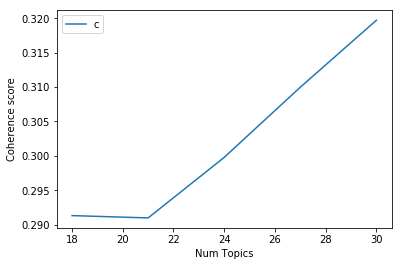

In [34]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 18 
max_k   = 31
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp[0], id2word=id2word[0], num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents["Breitbart News.txt"], dictionary=id2word[0], coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# using gensim implementation
gensim_model_breitbart = gensim.models.LdaModel(corpus=corp[0], id2word=id2word[0], num_topics = 30, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

In [36]:
vis = pyLDAvis.gensim.prepare(gensim_model_breitbart, corp[0], id2word[0])

# save visualization
pyLDAvis.save_html(vis, "breitbart_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...


### MSNBC

Checking model coherence for k =  18


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may

Checking model coherence for k =  21


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  24


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  27


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  30


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

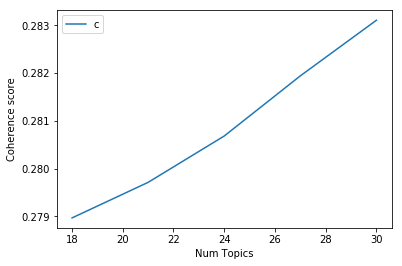

In [37]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 18 
max_k   = 31
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp[1], id2word=id2word[1], num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents["MSNBC.txt"], dictionary=id2word[1], coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# using gensim implementation
gensim_model_msnbc = gensim.models.LdaModel(corpus=corp[1], id2word=id2word[1], num_topics = 28, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

In [18]:
vis = pyLDAvis.gensim.prepare(gensim_model_msnbc, corp[1], id2word[1])

# save visualization
pyLDAvis.save_html(vis, "msnbc_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...


### NYTimes

Checking model coherence for k =  18


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  21


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  24


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  27


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  30


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

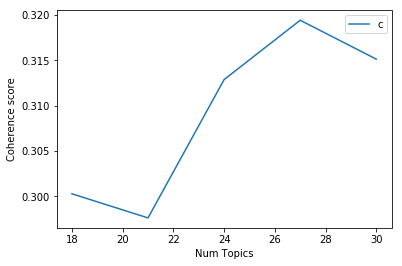

In [20]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 18 
max_k   = 31
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp[2], id2word=id2word[2], num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents["NYTimes.txt"], dictionary=id2word[2], coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# using gensim implementation
gensim_model_nyt = gensim.models.LdaModel(corpus=corp[2], id2word=id2word[2], num_topics = 27, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

In [22]:
vis = pyLDAvis.gensim.prepare(gensim_model_nyt, corp[2], id2word[2])

# save visualization
pyLDAvis.save_html(vis, "nyt_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...


### Fox News

Checking model coherence for k =  18


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may

Checking model coherence for k =  21


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  24


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  27


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  30


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

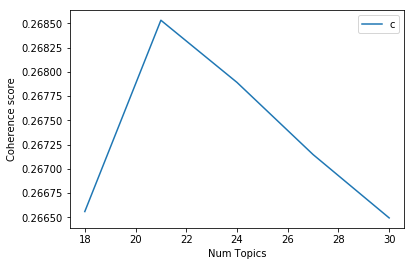

In [23]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 18 
max_k   = 31
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp[3], id2word=id2word[3], num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents["Fox.txt"], dictionary=id2word[3], coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# using gensim implementation
gensim_model_fox = gensim.models.LdaModel(corpus=corp[3], id2word=id2word[3], num_topics = 21, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

In [27]:
vis = pyLDAvis.gensim.prepare(gensim_model_fox, corp[3], id2word[3])

# save visualization
pyLDAvis.save_html(vis, "fox_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...


### CNN

Checking model coherence for k =  18


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may

Checking model coherence for k =  21


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  24


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  27


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  30


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

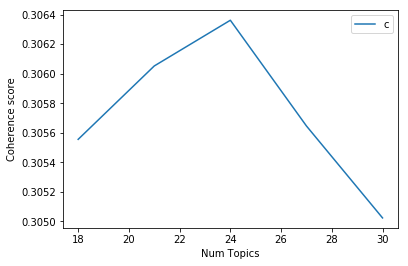

In [28]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 18 
max_k   = 31
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp[4], id2word=id2word[4], num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents["CNN.txt"], dictionary=id2word[4], coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# using gensim implementation
gensim_model_cnn = gensim.models.LdaModel(corpus=corp[4], id2word=id2word[4], num_topics = 24, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

In [30]:
vis = pyLDAvis.gensim.prepare(gensim_model_cnn, corp[4], id2word[4])

# save visualization
pyLDAvis.save_html(vis, "cnn_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...


# Word Embedding

In [47]:
from nltk.tokenize import sent_tokenize, word_tokenize  
 
import gensim 
from gensim.models import Word2Vec 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

# Create word2vec model for breitbart
breit_model = gensim.models.Word2Vec(documents["Breitbart News.txt"], min_count = 1,  
                              size = 150, window = 5) 

In [48]:
breit_model.most_similar(positive=["trump", "president"])

[('potus', 0.9201055765151978),
 ('trump2020', 0.890285849571228),
 ('duly', 0.8873425126075745),
 ('kag', 0.8855829238891602),
 ('maga', 0.881026566028595),
 ('brawler', 0.8794604539871216),
 ('accordance', 0.8766880035400391),
 ('unbelievebale', 0.8736110925674438),
 ('winning', 0.8693972826004028),
 ('donald', 0.868477463722229)]

In [49]:
breit_model.most_similar(positive=["bernie", "sanders"])

[('dementia', 0.9253321886062622),
 ('planed', 0.9215111136436462),
 ('bye', 0.9095470309257507),
 ('nominee', 0.9030048251152039),
 ('creepy', 0.8805380463600159),
 ('gropey', 0.879327654838562),
 ('dnc', 0.8782544732093811),
 ('sleepy', 0.8755536675453186),
 ('perv', 0.8744709491729736),
 ('condoning', 0.8744525909423828)]

In [50]:
# Create word2vec model for cnn
cnn_model = gensim.models.Word2Vec(documents["CNN.txt"], min_count = 1,  
                              size = 150, window = 5) 

In [51]:
cnn_model.most_similar(positive=["trump", "president"])

[('potus', 0.7743712067604065),
 ('prez', 0.6279233694076538),
 ('pres', 0.6181855201721191),
 ('presidents', 0.5810545682907104),
 ('presidency', 0.580527663230896),
 ('trumps', 0.5742763876914978),
 ('tsekulow', 0.5486694574356079),
 ('definitely', 0.5291301012039185),
 ('donald', 0.5261712670326233),
 ('either', 0.5197243690490723)]

In [58]:
cnn_model.most_similar(positive=["bernie", "sanders"])

[('warren', 0.7248958945274353),
 ('bernie2020', 0.7115386724472046),
 ('sander', 0.7068857550621033),
 ('bernies', 0.677345871925354),
 ('ejaixdgp8', 0.6756930351257324),
 ('klobuchar', 0.675658106803894),
 ('elim_biden_front', 0.6589881777763367),
 ('burnie', 0.658035933971405),
 ('tulsi', 0.6491904854774475),
 ('demeracates', 0.6428442001342773)]

In [59]:
# Create word2vec model for fox
fox_model = gensim.models.Word2Vec(documents["Fox.txt"], min_count = 1,  
                              size = 150, window = 5) 

In [67]:
fox_model.most_similar(positive=["democrats", "dems"], negative = ["republicans"])

[('demonrats', 0.6783923506736755),
 ('demorats', 0.6671479344367981),
 ('democraps', 0.578855037689209),
 ('dem', 0.5786755084991455),
 ('democrat', 0.5309840440750122),
 ('democrates', 0.5288847088813782),
 ('dims', 0.4910028874874115),
 ('demoncraps', 0.4764707386493683),
 ('lefties', 0.4459090828895569),
 ('leftists', 0.443939745426178)]

In [65]:
fox_model.most_similar(positive=["bernie", "sanders"])

[('sander', 0.7158198356628418),
 ('burnie', 0.6838415861129761),
 ('bernies', 0.6692448854446411),
 ('bolshevik', 0.6535025835037231),
 ('fakabee', 0.647866427898407),
 ('bros', 0.6372280716896057),
 ('warren', 0.6303413510322571),
 ('comrade', 0.6206515431404114),
 ('shick', 0.6117165684700012),
 ('nomination', 0.6089827418327332)]